memo to myself: careful with copies of dataframes. Always verify when using chained indexing
**Outside of simple cases, it’s very hard to predict whether it will return a view or a copy (it depends on the memory layout of the array, about which pandas makes no guarantees), and therefore whether the __setitem__ will modify dfmi or a temporary object that gets thrown out immediately afterward. That’s what SettingWithCopy is warning you about!**
 

**memo2 ** sometimes hard to say whether to delete outliers or leave themm when target variables are in the pattern.

Variables to find answers for strange behavoir:
- Shot density
- Shot Total

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import outlier_removal as out
from sklearn import linear_model


## helpful functions:
### correlated columns
To find, for a given column, another column with the highest possible correlation

In [2]:
def find_cor(name,df):
    cor=df.corr()
    index=df.columns.get_loc(name)
    if(index>2):#Dates fall out, to be corrected when we have dates
        index=index-3
    cor=cor[name]
    c=[np.abs(e) for e in cor]
    c[index]=0 # highsest correltion is with it self
    max_cor=np.max(c)
    print(max_cor)
    max_cor_index=c.index(max_cor)
    if( max_cor_index>2):
        max_cor_index=max_cor_index+3 # Dates fall out, calculate dataframe index
    max_cor_name=df.columns[max_cor_index]
    print(max_cor_name)
    return max_cor_name

### Linear 1D fit

In [3]:
def lin_regr(namex,namey):
    model = linear_model.LinearRegression()
    nansx= np.array(np.isnan(df[namex]))
    nansy= np.array(np.isnan(df[namey]))
    nan=np.logical_or(nansx,nansy)
    df_nonans=df[np.logical_not(nan)]
    x=df_nonans[namex].values
    x=[e for e in x]
    x=np.array(x)
    y=df_nonans[namey].values
    y=[e for e in y]
    y=np.array(y)
    model.fit(x[:, np.newaxis], y)
    res= model.coef_
    print("we estimate y= ax+b, with a equals:"+ str(res))
    return res

### Outliers and visualization

In [4]:
def vis_and_return_Outl(df,column,factor_iqr,a=-6,b=6,delta=0.5):
    bins2=np.arange(a,b,delta)
    df.boxplot(column,return_type='dict',whis=factor_iqr)
    plt.title('outliers')
    y=df[column]
    x=range(1, len(y)+1)
   # plt.figure()
    #plt.title(column+ " plottet against random")
    #plt.plot(x,y,'.')
    
    plt.figure()
    plt.hist(df.dropna()[column],bins=bins2,normed=True,color='g')
    plt.xlabel(column)
    
   
    plt.figure()
    f, axarr = plt.subplots(ncols=2)
    f.set_figwidth(15)
    axarr[0].scatter(df[column],df['GasCum360'],s=6,color='r')
    axarr[0].set_title("GasCum360")
    axarr[0].set_xlabel(column)
    axarr[1].scatter(df[column],df['OilCum360'],color='black',s=6)
    axarr[1].set_xlabel(column)
    axarr[1].set_title("OilCum360")
    
    #quartiles
    Q1=np.percentile(df.dropna()[column],25)
    Q3=np.percentile(df.dropna()[column],75)
    iqr=Q3-Q1
    
    #identify outliers
    mean=np.mean(df[column])
    index=np.logical_or(df[column]< Q1 - factor_iqr*iqr, df[column]> Q3 + factor_iqr*iqr)
    outliers=df[index]
    
    # plot with target variables
    
    return outliers
    

# The Actual Data Cleaning


In [5]:
df=pd.read_csv('TrainSample.csv',sep=';' )

We select only those 363 lines, that do not have the group of 18 featrues missing

In [6]:
df=df[~ np.logical_and(np.isnan(df['Shot_Total']), np.isnan(df['Frac_Gradient (PSI/ft)'])  )] ## remove 97 lines with 18 missing
len(df)


363

## ShutInPressure_Fil (KPa) and ShutInPressure_Initial
As shown in the global analysis, these two variables belong to the set of variables that have 97 missing lines in common.
We decided to cut these 97 lines off ( for these variables only) and do the cleaning on the remaining 363 lines.
We treat them together as they have high correlation. We can estimate the missing vals of one by the ones of another. But we have to be careful not to use estimations of in one of the estiamtions of another.
Also we want to remove the outliers before, so they do not influence the imputation and they can be estimated together with the missing values.


### Outliers ....Fil
we use our customzied function vis_and return Outl

,API,Surf_X,Surf_Y,Date_Drilling,Date_Completion,Date_Production,Lateral_Length (ft),Depth_TVD_PPLS (ft),Erosion_PPLS (ft),Pressure_PPLS (PSI),...,Min_Rate_Slurry (bpm),ShutInPressure_Fil (KPa),ShutInPressure_Initial (KPa),ISIP (KPa),Shot_Density (shots/ft),Shot_Total,Proppant_per_ft (kg/ft),Stage_Spacing (ft),GasCum360,OilCum360
298,169,-0.361700,0.934645,13/02/2014,24/08/2014,21/10/2014,-0.098057,-1.130276,-0.687802,-0.481296,...,0.277007,3.052486,0.936939,0.349276,1.627854,0.181738,0.115375,-0.177129,1.518204,-0.170041
340,456,0.280183,-0.135503,12/05/2013,27/10/2013,20/12/2013,1.483162,-0.176755,-0.829416,0.404333,...,0.186816,-6.253073,1.056170,0.858999,-0.988721,0.591386,-0.761109,-0.152933,1.153736,-0.419644


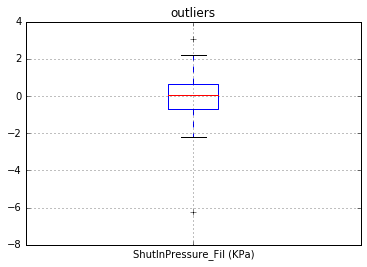

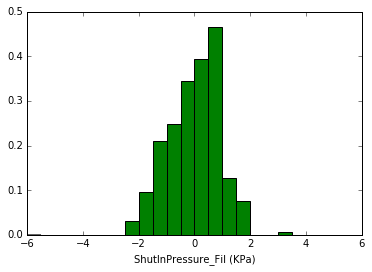

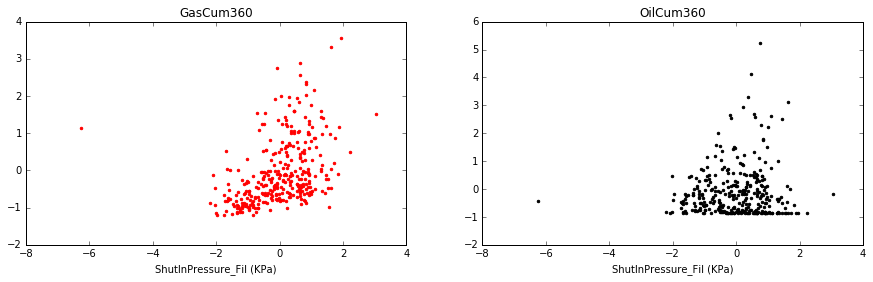

In [7]:
outs_Fil=vis_and_return_Outl(df,"ShutInPressure_Fil (KPa)",1.5,a=-6,b=5)
outs_Fil

We delete the  outliers (API =169 and 456 ). ( to na)

In [8]:
rows=outs_Fil.index
df.loc[rows,'ShutInPressure_Fil (KPa)']=np.nan
df.loc[rows,'ShutInPressure_Fil (KPa)']# to verify the removal

298   NaN
340   NaN
Name: ShutInPressure_Fil (KPa), dtype: float64

### Outliers  Shut.....Inital



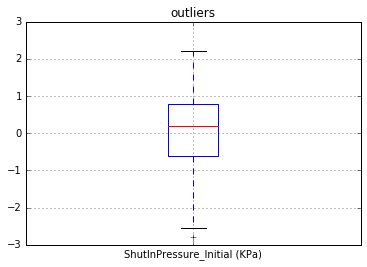

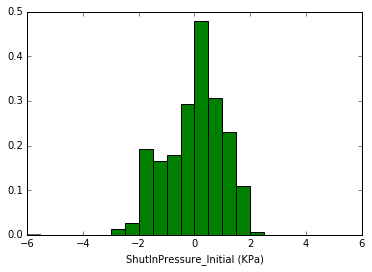

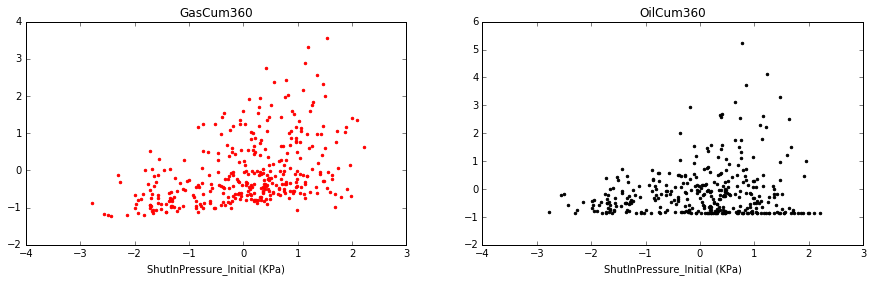

In [9]:
outs_Initial=vis_and_return_Outl(df,"ShutInPressure_Initial (KPa)",1.5)


using the histogram, we decide not to change the small outlier.

### Replace Missing Values

In [10]:
missing_Fil= np.isnan(df['ShutInPressure_Fil (KPa)'])
print('missing Fil:     '+  str(sum(missing_Fil)))
missing_Init= np.isnan(df['ShutInPressure_Initial (KPa)'])
print('missing Initial:  '+ str(sum(missing_Init)))
missing_both=np.logical_and(missing_Fil,missing_Init)
print('missing both:     '+ str(sum(missing_both)))
no_missing=np.logical_not(missing_both)
no_missing_Fil=np.logical_not(missing_Fil)
no_missing_Init=np.logical_not(missing_Init)
only_Fil_missing=np.logical_and(missing_Fil,no_missing_Init)
only_Init_missing=np.logical_and(missing_Init,no_missing_Fil)
cor=df[['ShutInPressure_Initial (KPa)','ShutInPressure_Fil (KPa)']].corr()
print('correlation     ' + str(cor.iloc[0,1]))
#df['ShutInPressure_Fil (KPa)'][missing_Fil]

missing Fil:     33
missing Initial:  6
missing both:     1
correlation     0.786873117403


### Estimate missing vals of ShutIn...Fil
As there is a high correlation between the two variables, we can  use linear regression to estimate the missing values that they do not have in common. The line, that both of them are missing has to be estimated by the means.

So we can try a linear fit with our customzed function:

In [11]:
a=lin_regr(find_cor('ShutInPressure_Fil (KPa)',df),'ShutInPressure_Fil (KPa)')
m1=np.mean(df['ShutInPressure_Initial (KPa)'])
m2=np.mean(df['ShutInPressure_Fil (KPa)'])
rows_Fil=df[only_Fil_missing].index
rows_both=df[missing_both].index
df.loc[rows_Fil,'ShutInPressure_Fil (KPa)']=(df['ShutInPressure_Initial (KPa)'][only_Fil_missing]- m1)*a+ m2
df.loc[rows_both,'ShutInPressure_Fil (KPa)']=m2
print len(rows_Fil)

0.786873117403
ShutInPressure_Initial (KPa)
we estimate y= ax+b, with a equals:[ 0.68360325]
32


we could not estimate one value as its missing in ShutInPressure_Initial as well. So we have to replace it with the mean.

now we have no more missing values. make scatter plot to check how the estimation was.

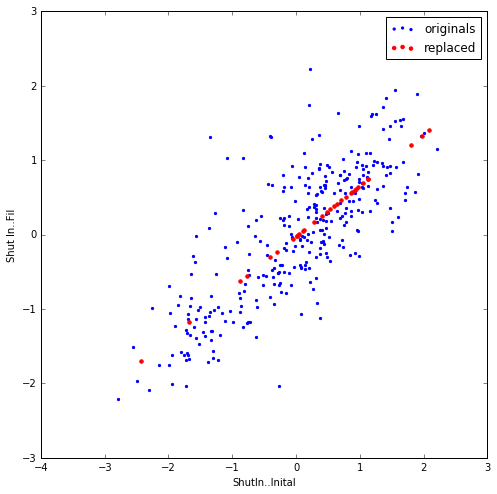

In [12]:
plt.figure(figsize=(8,8))
plt.scatter(df['ShutInPressure_Initial (KPa)'][no_missing_Fil],df['ShutInPressure_Fil (KPa)'][no_missing_Fil],color='blue',s=5,label='originals')
plt.scatter(df['ShutInPressure_Initial (KPa)'][~no_missing_Fil],df['ShutInPressure_Fil (KPa)'][~no_missing_Fil],color='red',s=12,label='replaced')
plt.xlabel('ShutIn..Inital')
plt.ylabel('Shut In..Fil')
plt.legend()



### Estimate missing vals of ShutIn...Initial


In [13]:
a=lin_regr(find_cor('ShutInPressure_Initial (KPa)',df),'ShutInPressure_Initial (KPa)')
m1=np.mean(df['ShutInPressure_Fil (KPa)'])
m2=np.mean(df['ShutInPressure_Initial (KPa)'])
rows_In=df[only_Init_missing].index
df.loc[rows_In,'ShutInPressure_Initial (KPa)']=(df['ShutInPressure_Fil (KPa)'][only_Init_missing]- m1)*a+ m2
df.loc[rows_both,'ShutInPressure_Initial (KPa)']=m2# estimate with mean

0.799457793897
ShutInPressure_Fil (KPa)
we estimate y= ax+b, with a equals:[ 0.93580418]


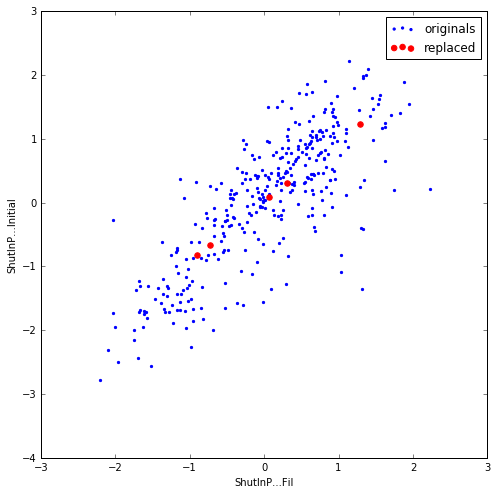

In [14]:
plt.figure(figsize=(8,8))
plt.scatter(df['ShutInPressure_Fil (KPa)'][~only_Init_missing],df['ShutInPressure_Initial (KPa)'][~only_Init_missing],color='blue',s=5,label='originals')
plt.scatter(df['ShutInPressure_Fil (KPa)'][only_Init_missing],df['ShutInPressure_Initial (KPa)'][only_Init_missing],color='red',s=30,label='replaced')
plt.ylabel('ShutInP...Initial')
plt.xlabel('ShutInP...Fil')
plt.legend()


## ISIP (KPa
Normalized Instantaneous Shut-In Pressure (PSI), proxy to the stress in the reservoir
# Outliers


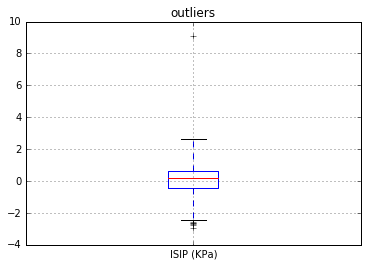

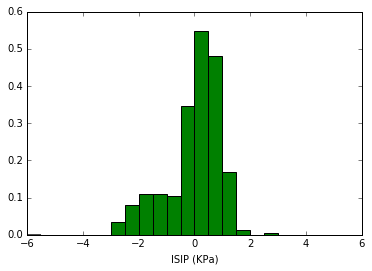

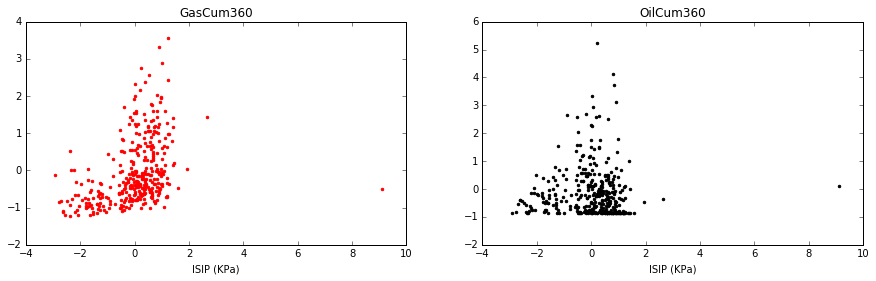

In [15]:
outs_Isip=vis_and_return_Outl(df,"ISIP (KPa)",2)
rows=df["ISIP (KPa)"][df["ISIP (KPa)"]>2].index
df.loc[rows,"ISIP (KPa)"]=np.nan # verified

The boxplot is misleading here as it seems we have two clusters of values. when the treshold 1.5 IQR is chosen, we would have plenty of outliers. Rather than using the boxplot, we use the second plot ( ISIP vs random) to indentify and delete the two biggest outliers.

We can see that ISIP has a high power of prediction for both OilCum and GasCum.
We choose the treshold t= -0.8 and get

for t < -0.8      OilCum <  1        except 2 values

for t < -0.8      GasCum < 0.5   

Apart from that we remark a linear tendency of the maximum Oil and Gas with ISIP.

### Conclusion
As ISIP is a measure for the stress in the reservoir, it makes sense that it determines the quantity of Oil and Gas that is coming out of the reservoir.

### We could use ISIP for splitting the dataset.
The question why it splits in two clusters still is unsolved.

### Replace missing values
in fact it is just the outliers we have to estimate.

In [16]:
missing_Isip= np.isnan(df['ISIP (KPa)'])
print('missing Isip:     '+  str(sum(missing_Isip)))
df[missing_Isip]

missing Isip:     4


,API,Surf_X,Surf_Y,Date_Drilling,Date_Completion,Date_Production,Lateral_Length (ft),Depth_TVD_PPLS (ft),Erosion_PPLS (ft),Pressure_PPLS (PSI),...,Min_Rate_Slurry (bpm),ShutInPressure_Fil (KPa),ShutInPressure_Initial (KPa),ISIP (KPa),Shot_Density (shots/ft),Shot_Total,Proppant_per_ft (kg/ft),Stage_Spacing (ft),GasCum360,OilCum360
58,553,0.126157,-0.220907,15/03/2012,29/04/2012,14/07/2012,-0.647532,0.126219,0.120175,0.447324,...,0.332100,-0.169081,-1.118669,NaN,0.667339,-0.560750,-0.305301,2.339477,-0.494240,0.117476
190,261,0.390100,-0.246404,12/05/2013,10/02/2014,12/04/2014,-1.174605,-0.097463,-1.162731,0.021191,...,0.274975,0.382667,0.600586,NaN,-1.253690,0.181738,-0.456037,-0.227539,-0.399198,-0.661032
260,562,-0.290266,0.913680,24/12/2014,09/01/2016,22/04/2016,3.164569,-1.171615,-0.643050,-0.473676,...,-0.158848,1.308340,-0.394111,NaN,0.667339,-0.560750,-0.639881,-0.105355,1.448017,-0.368460
438,83,0.444653,-0.553453,24/02/2012,27/04/2012,10/07/2012,-0.539877,0.377543,-1.217313,0.367718,...,-0.621647,-0.626338,-0.875424,NaN,-0.293176,-1.303237,-0.137177,1.593895,-0.436901,-0.081575


In [17]:
find_cor('ISIP (KPa)',df)

0.854414576898
ShutInPressure_Fil (KPa)


'ShutInPressure_Fil (KPa)'

As ShutInPressure_Fil (KPa) has missing values or outliers in the same columns, we check the correlation with 
ShutIn..Inital which is  0.63  ( not shown here.
Luckily ShutInP....Fil did not have missing vals in the same columns. So we can use it to estimate the two missing vals:

we estimate y= ax+b, with a equals:[ 0.69772658]


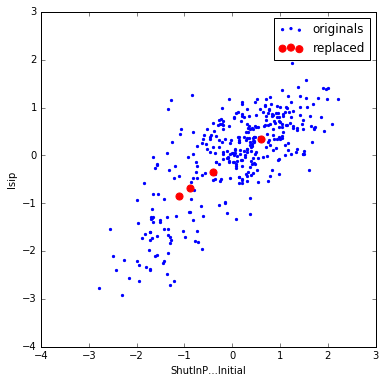

In [18]:
a3=lin_regr('ShutInPressure_Initial (KPa)','ISIP (KPa)')
m1=np.mean(df['ShutInPressure_Initial (KPa)'])
m2=np.mean(df['ISIP (KPa)'])
rows=df['ISIP (KPa)'][missing_Isip].index
df.loc[rows,'ISIP (KPa)']=(df['ShutInPressure_Initial (KPa)'][missing_Isip]- m1)*a3+ m2

plt.figure(figsize=(6,6))
plt.scatter(df['ShutInPressure_Initial (KPa)'][~missing_Isip],df['ISIP (KPa)'][~missing_Isip],color='blue',s=5,label='originals')
plt.scatter(df['ShutInPressure_Initial (KPa)'][missing_Isip],df['ISIP (KPa)'][missing_Isip],color='red',s=50,label='replaced')
plt.xlabel('ShutInP...Initial')
plt.ylabel('Isip')
plt.legend()


# Shot_Density (shots/ft)
<< *Normalized Total number of shots in the well per feet (shots/ft)*>>
 
It looks like we have a categorical variable here. We do not see a outlier on the second plot either. But we will have to find out whether it is really categorical.
We notice that the variable has two big 'centers' of distribution.

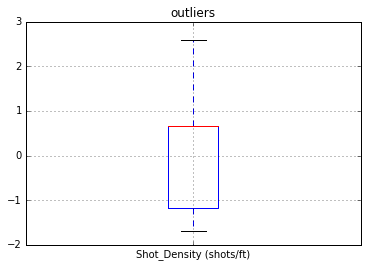

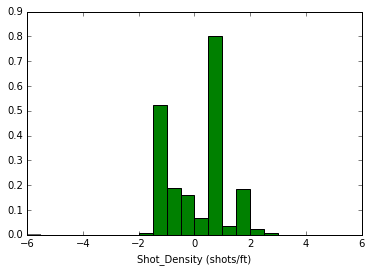

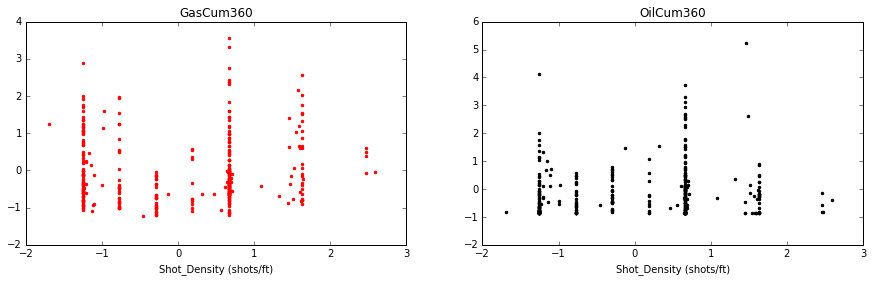

In [19]:
outs_SD=vis_and_return_Outl(df,"Shot_Density (shots/ft)",1.5)

It looks like the variable splits into two clusters at -1.5 and at 0.5. Lets investigate this further.

We cannot notice a huge difference in the target varibles between the two clusters. **Continue later**


In [20]:
# not important now
#df_d1=df[df['Shot_Density (shots/ft)']>0]
#df_d2=df[df['Shot_Density (shots/ft)']<= 0]
#df_3=(df_d1.mean()-df_d2.mean())/(np.sqrt(df.var()))
#df_3.sort_values()


In [21]:
z=df['Shot_Density (shots/ft)']
unique_vals=list(z.unique())
#u=[unique_vals.index(e) for e in z]
len(unique_vals)

59

As we have 59 different values, we assum that Shot_Density is just a discretized numerical value, as it expresses a physcial value. We check for missing values...

In [22]:
missing_SD= np.isnan(df['Shot_Density (shots/ft)'])
print('missing SD:     '+  str(sum(missing_SD)))
df[missing_SD]


missing SD:     1


,API,Surf_X,Surf_Y,Date_Drilling,Date_Completion,Date_Production,Lateral_Length (ft),Depth_TVD_PPLS (ft),Erosion_PPLS (ft),Pressure_PPLS (PSI),...,Min_Rate_Slurry (bpm),ShutInPressure_Fil (KPa),ShutInPressure_Initial (KPa),ISIP (KPa),Shot_Density (shots/ft),Shot_Total,Proppant_per_ft (kg/ft),Stage_Spacing (ft),GasCum360,OilCum360
131,452,1.217796,-0.884183,13/01/2012,15/03/2012,22/06/2012,-1.394893,0.236538,1.769934,-2.259171,...,0.80519,-1.229073,-1.892207,-1.717553,NaN,-1.303237,-0.295429,2.260683,-0.774324,-0.786149


As the highest correlation with another variable is 0.33 and we have only one missing value we just replace by mean.

In [23]:
df[missing_SD]=np.mean(df['Shot_Density (shots/ft)']) # verified


# Shot_Total
*<< Normalized Total number of shots in the well >>*
wikipedia:
*Oil well shooting is a method of increasing production of an oil well by removing obstructions to drilling, straightening crooked holes, preventing water penetration, and/or increase the flow of oil*

As the variable is a normalized integer, we expect discrete values.
We notice the same behavior as for Shot_Density.



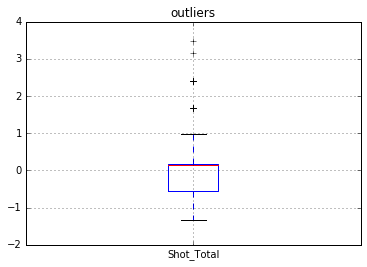

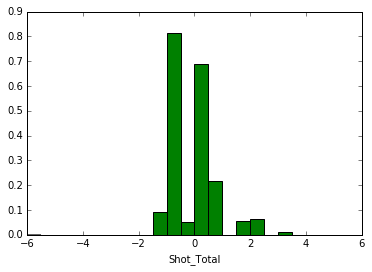

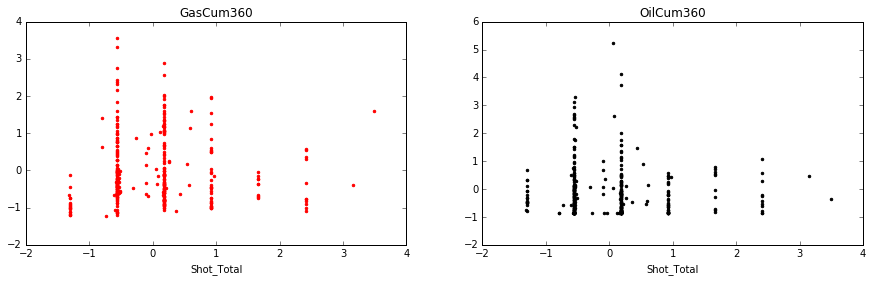

In [24]:
outs_ST=vis_and_return_Outl(df,"Shot_Total",1.5)

We replace the two highest outliers with max value that the variable has when they are left out.

In [25]:
max=np.max(df['Shot_Total'][df['Shot_Total']<3])
r_ind=df[df['Shot_Total']>3].index
df.loc[r_ind,'Shot_Total']=max


### Missing Values
we have one missing value

In [26]:
missing_ST= np.isnan(df['Shot_Total'])
print('missing SD:     '+  str(sum(missing_ST)))
df[missing_ST]

missing SD:     1


,API,Surf_X,Surf_Y,Date_Drilling,Date_Completion,Date_Production,Lateral_Length (ft),Depth_TVD_PPLS (ft),Erosion_PPLS (ft),Pressure_PPLS (PSI),...,Min_Rate_Slurry (bpm),ShutInPressure_Fil (KPa),ShutInPressure_Initial (KPa),ISIP (KPa),Shot_Density (shots/ft),Shot_Total,Proppant_per_ft (kg/ft),Stage_Spacing (ft),GasCum360,OilCum360
259,670,-0.41916,-0.114792,27/11/2013,03/06/2014,05/08/2014,0.24731,0.526063,0.884547,-0.8916,...,0.467576,-0.517849,-0.107408,-1.206691,0.318061,NaN,0.466094,0.03767,-0.62725,1.536103


In [27]:
find_cor('Shot_Total',df) 

0.251076778968
Shot_Density (shots/ft)


'Shot_Density (shots/ft)'

As we could not find highly correlated columns, we replace the missing value with the mean.

In [28]:
df.loc[259,'Shot_Total']=np.mean(df['Shot_Total']) 


# Proppant_per_ft
*Normalized Weight of proppant pumped during completion normalzied per feet (kg/ft)*

It looks we have two clusters again, but this time the first cluster is a lot bigger.


## Outliers


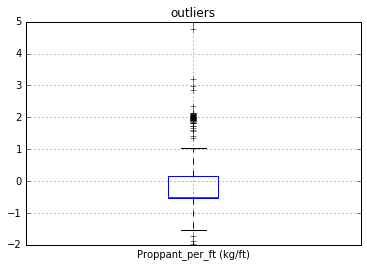

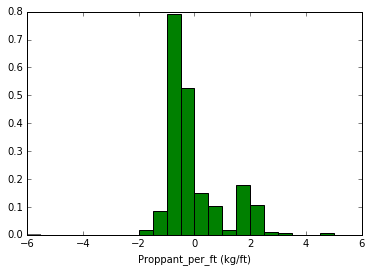

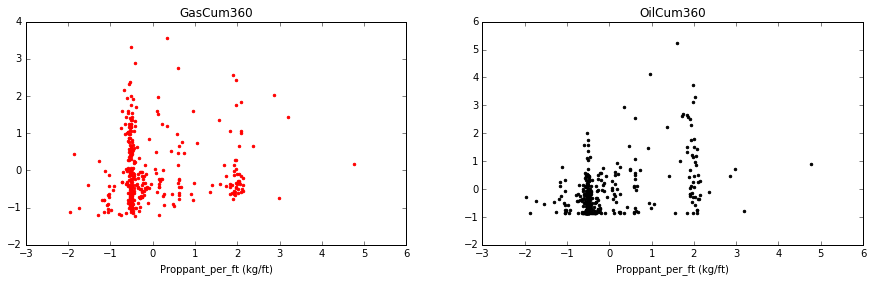

In [29]:
outs_Propp=vis_and_return_Outl(df,"Proppant_per_ft (kg/ft)",1.5)

Looking at the histogram, we decide to change the outlying values > 4 to a less extreme value.

In [30]:
rows=df[df["Proppant_per_ft (kg/ft)"]>4].index
df.loc[rows,"Proppant_per_ft (kg/ft)"]=3

## Missing Values

In [31]:
missing_Prop=np.isnan(df["Proppant_per_ft (kg/ft)"]) # 1 value
find_cor('Proppant_per_ft (kg/ft)',df)

0.806172169783
Proppant_in_Formation (kg)


'Proppant_in_Formation (kg)'

we have found a highly correlated column. Unfortunately we have a missing value in the same row.
Luckily Proppant_Designed is also very correlated (cor = 0.8) and does not have missing vals in the same row.

In [32]:
a3=lin_regr('Proppant_Designed (kg)','Proppant_per_ft (kg/ft)')
m1=np.mean(df['Proppant_Designed (kg)'])
m2=np.mean(df['Proppant_Designed (kg)'])
rows=df['Proppant_per_ft (kg/ft)'][missing_Prop].index
df.loc[rows,'Proppant_per_ft (kg/ft)']=(df['Proppant_Designed (kg)'][missing_Prop]- m1)*a3+ m2

we estimate y= ax+b, with a equals:[ 0.77669993]


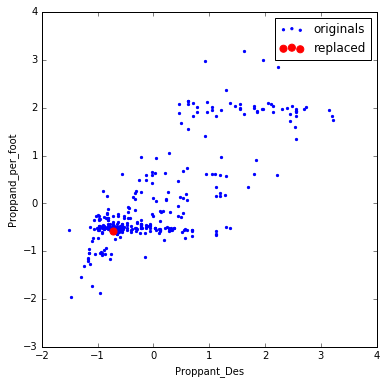

In [33]:
plt.figure(figsize=(6,6))
plt.scatter(df['Proppant_Designed (kg)'][~missing_Prop],df['Proppant_per_ft (kg/ft)'][~missing_Prop],color='blue',s=5,label='originals')
plt.scatter(df['Proppant_Designed (kg)'][missing_Prop],df['Proppant_per_ft (kg/ft)'][missing_Prop],color='red',s=50,label='replaced')
plt.xlabel('Proppant_Des')
plt.ylabel('Proppand_per_foot')
plt.legend()

# Stage_Spacing (ft) VERY IMPORTANT VARIABLE
we can see a high linear ( or hyperbolic) correlation with OilCum. A little bit less , but still high with GasCum.


## Outliers
we replace one huge outliers by the mean. The other outliers carry important information about the target variables.


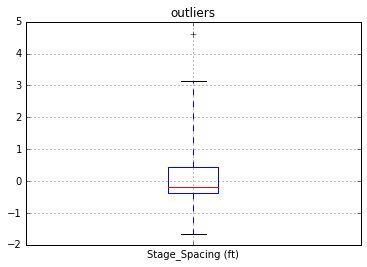

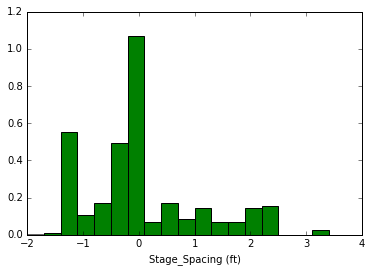

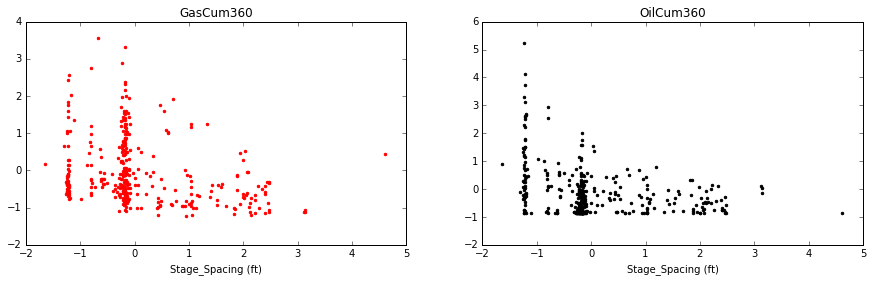

In [34]:
outs_StS=vis_and_return_Outl(df,"Stage_Spacing (ft)",4,delta=0.3,a=-2,b=4)



In [35]:
rows=outs_StS.index
df.loc[rows,"Stage_Spacing (ft)"]=np.mean(df['Stage_Spacing (ft)'])

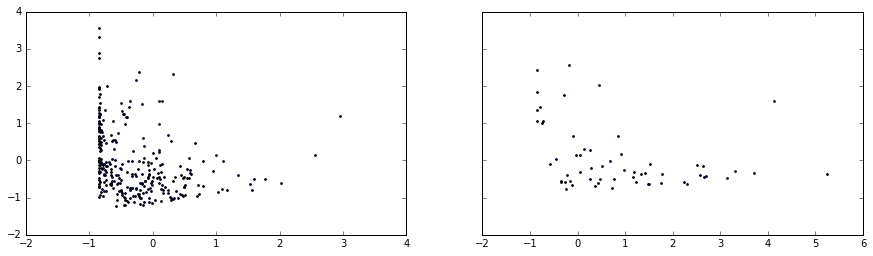

In [36]:
#Experiment:
f, axarr = plt.subplots(ncols=2,sharey=True)
f.set_figwidth(15)

#axarr[0].set_title("GasCum360")
#axarr[0].set_xlabel(column)
df1=df[df['Stage_Spacing (ft)']> -1 ]
df2=df[df['Stage_Spacing (ft)']<= -1 ]

axarr[0].scatter(df1['OilCum360'],df1['GasCum360'],s=3)

axarr[1].scatter(df2['OilCum360'],df2['GasCum360'],s=3)


split into the two culsters does not help much so far.

# Avg_Breakdown_Pressure (KPa)

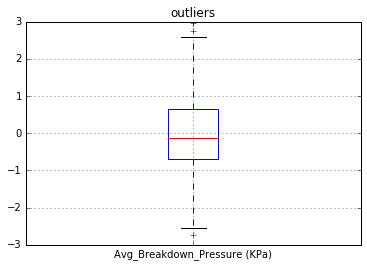

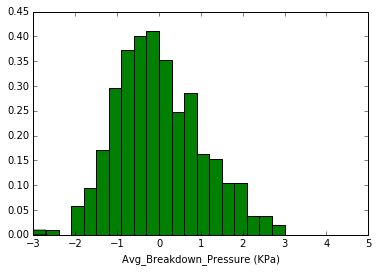

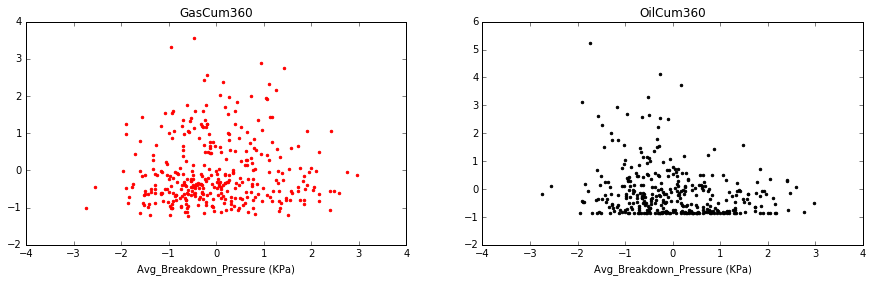

In [37]:
outs_Abp=vis_and_return_Outl(df,'Avg_Breakdown_Pressure (KPa)',1.5,delta=0.3,a=-3,b=5)



We  do not see huge outliers.

## Missing Values

In [38]:
missing_Abp=np.isnan(df["Avg_Breakdown_Pressure (KPa)"]) # 1 value
df[missing_Abp] # two missing values


,API,Surf_X,Surf_Y,Date_Drilling,Date_Completion,Date_Production,Lateral_Length (ft),Depth_TVD_PPLS (ft),Erosion_PPLS (ft),Pressure_PPLS (PSI),...,Min_Rate_Slurry (bpm),ShutInPressure_Fil (KPa),ShutInPressure_Initial (KPa),ISIP (KPa),Shot_Density (shots/ft),Shot_Total,Proppant_per_ft (kg/ft),Stage_Spacing (ft),GasCum360,OilCum360
437,63,0.031635,-0.029018,04/09/2012,14/12/2012,23/06/2013,-0.583437,-0.099078,0.623752,-0.009573,...,0.440142,0.552988,0.588143,0.978815,-0.293176,0.970631,-0.551515,0.278012,-0.143814,0.429637
458,381,0.539683,-0.054399,23/10/2011,15/03/2012,22/06/2012,-0.633220,-0.522279,-1.239967,0.250447,...,0.585440,-0.851824,-1.649836,-0.797323,0.667339,-0.560750,-0.262110,1.875340,-0.158165,-0.724854


As there is no other variable with high correlation, we just replace missing values by mean.

In [39]:
rows=df[missing_Abp].index
df.loc[rows,'Avg_Breakdown_Pressure (KPa)']=np.mean(df['Avg_Breakdown_Pressure (KPa)'])


# Avg/Min/Max_Treating_Pressure (KPa)
we treat this variables together  as they are highly correlated.

cor(Avg,Min) =0.7
cor(Avg,Max) =0.5
cor(Min,Max) =0.4

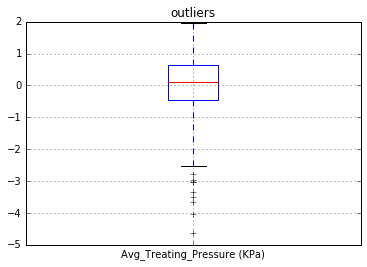

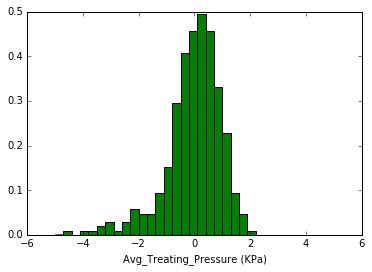

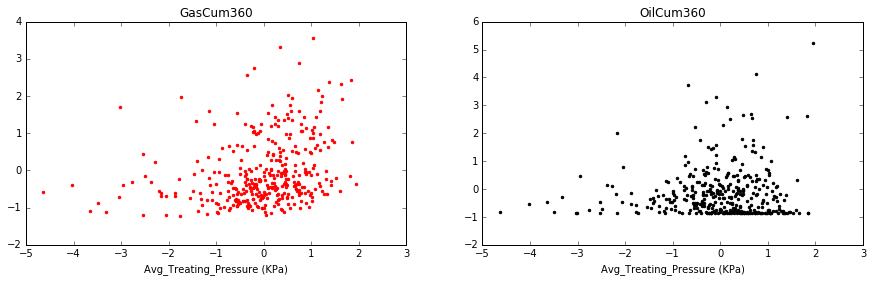

In [40]:
outs_Atp=vis_and_return_Outl(df,'Avg_Treating_Pressure (KPa)',2,delta=0.3,a=-5,b=5)#
#df.corr()['Avg_Treating_Pressure (KPa)'].sort_values()#,'Avg_Treating_Pressure (KPa)','Max_Treating_pressure (KPa)']
#df.corr()['Max_Treating_pressure (KPa)'].sort_values()#,'Avg_Treating_Pressure (KPa)','Max_Treating_pressure (KPa)']

To the left side of the histogram, it seems that there are same outliers.
We plot against correlated variables to see more..

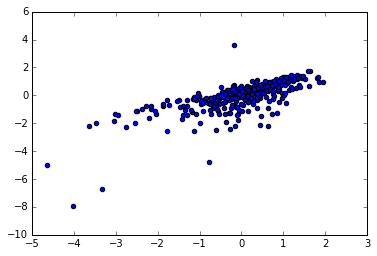

In [41]:

plt.scatter(df['Avg_Treating_Pressure (KPa)'],df['Min_Treating_Pressure (KPa)'])

    We decided only to delete the outliers with values < - 2.5
    

In [42]:
rows=outs_Atp.index
df.loc[rows,'Avg_Treating_Pressure (KPa)']=np.nan


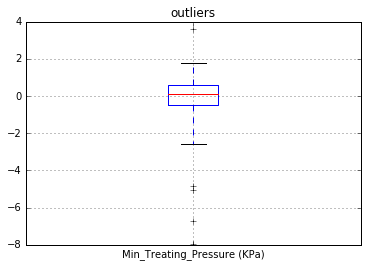

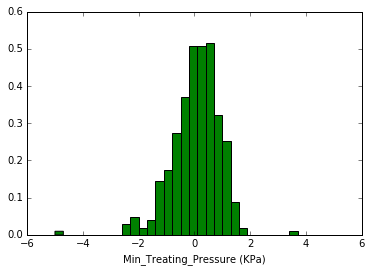

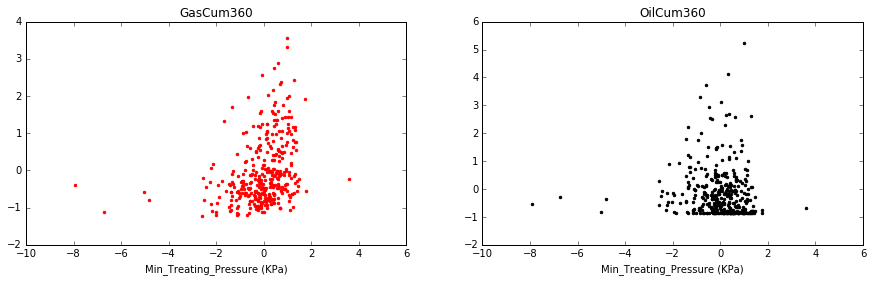

In [43]:
outs_Mitp=vis_and_return_Outl(df,'Min_Treating_Pressure (KPa)',2,delta=0.3,a=-5,b=5)
rows=outs_Mitp.index
df.loc[rows,'Min_Treating_Pressure (KPa)']=np.nan # delete outliers determinded by boxplot

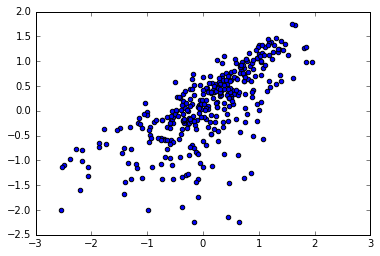

In [44]:
plt.scatter(df['Avg_Treating_Pressure (KPa)'],df['Min_Treating_Pressure (KPa)'])

,API,Surf_X,Surf_Y,Date_Drilling,Date_Completion,Date_Production,Lateral_Length (ft),Depth_TVD_PPLS (ft),Erosion_PPLS (ft),Pressure_PPLS (PSI),...,Min_Rate_Slurry (bpm),ShutInPressure_Fil (KPa),ShutInPressure_Initial (KPa),ISIP (KPa),Shot_Density (shots/ft),Shot_Total,Proppant_per_ft (kg/ft),Stage_Spacing (ft),GasCum360,OilCum360
45,333,0.994444,-0.744697,02/07/2013,12/01/2014,01/03/2014,-1.440320,0.206008,1.476156,-0.651776,...,0.231913,0.341291,0.540059,0.594771,-1.253690,0.181738,-0.260873,-0.318573,-0.576744,-0.838597
99,728,0.588880,-0.914507,05/07/2013,27/08/2013,13/11/2013,0.493111,0.884290,-1.556034,-0.118940,...,0.144927,0.006552,0.050392,0.129965,-1.253690,0.181738,-0.613397,-0.132048,-0.321493,0.132009
135,471,1.264097,-1.137481,21/05/2011,09/09/2011,16/10/2011,-1.257991,0.727477,1.100536,-1.500419,...,0.729495,0.312803,0.315738,0.082592,-0.293176,1.666713,-0.210842,1.020480,-0.150183,-0.729910
137,143,1.656362,-2.740075,15/12/2011,07/02/2012,22/04/2012,-1.486991,2.555879,-1.301568,-3.036875,...,0.707418,-0.823084,-1.820349,-1.645197,-0.293176,-1.303237,0.155804,1.063242,-1.208757,-0.445552
186,636,0.889209,-1.297541,28/03/2011,28/06/2011,24/07/2011,0.010220,1.167945,0.100313,0.686254,...,0.763242,0.001847,0.043509,-0.145505,0.667339,2.409201,1.409488,0.003925,-0.399839,0.451754
258,720,0.902393,-1.663890,12/04/2014,10/10/2014,30/10/2014,-0.810570,1.685594,0.256038,1.073064,...,0.315542,-0.100621,0.416589,0.191387,0.667339,-0.560750,1.900151,-1.206977,-0.761830,-0.245870
286,224,0.130506,-0.004360,14/07/2013,29/12/2013,13/03/2014,0.120364,-0.242350,-0.011653,0.328766,...,0.239651,0.010082,-0.081400,-0.053163,-1.205261,0.256611,-0.423761,-0.245987,0.220565,0.099782
326,544,0.856238,-0.226241,28/07/2013,04/02/2014,26/03/2014,-0.068187,-0.498395,0.449106,1.570464,...,0.181206,0.162901,0.279104,-0.380946,-1.253690,0.181738,-0.387433,-0.260255,1.706054,-0.846812
356,27,-0.117387,0.586584,29/03/2013,09/10/2013,17/06/2014,-1.229366,-0.900848,0.129027,-0.652060,...,0.163033,-0.341383,-0.333962,0.404580,-0.293176,1.666713,-0.222547,-0.625425,-0.218667,-0.807634
370,296,-0.011177,0.158162,31/12/2013,03/07/2014,04/09/2014,1.262252,-0.361210,0.703886,-0.497497,...,0.383983,0.213072,0.032904,0.002455,-1.253690,0.181738,-0.514001,-0.175529,1.252449,-0.458190


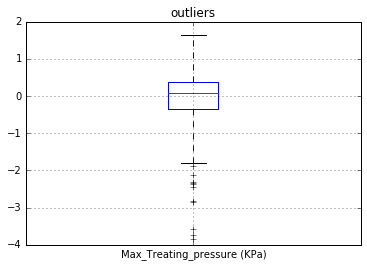

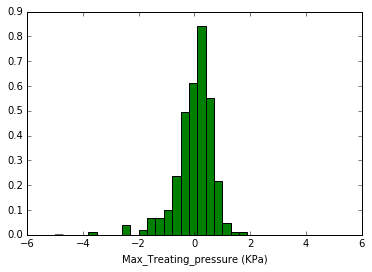

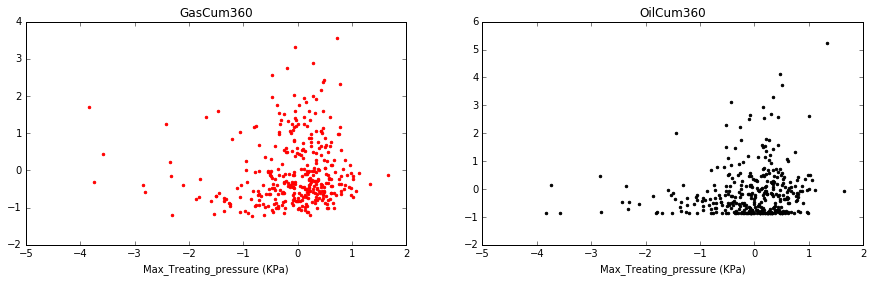

In [45]:
outs_Matp=vis_and_return_Outl(df,'Max_Treating_pressure (KPa)',2,delta=0.3,a=-5,b=5)
outs_Matp

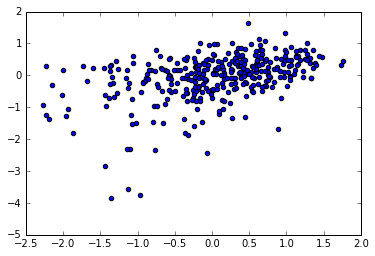

In [46]:
plt.scatter(df['Min_Treating_Pressure (KPa)'],df['Max_Treating_pressure (KPa)'])

We choose to delete outliers < 2.5  ( see oil and gas plot)

In [47]:
rows=outs_Matp.index
df.loc[rows,'Max_Treating_pressure (KPa)']=np.nan # delete outliers determinded by boxplot
rows2=df[df['Max_Treating_pressure (KPa)']> 1.25].index
df.loc[rows2,'Max_Treating_pressure (KPa)']=np.nan # delete outliers > 1.25 ( see plot)

### to be rethought

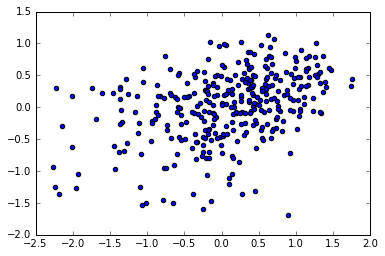

In [48]:
plt.scatter(df['Min_Treating_Pressure (KPa)'],df['Max_Treating_pressure (KPa)'])

## replace the missing values


In [49]:
missing_Atp=np.isnan(df["Avg_Treating_Pressure (KPa)"])
missing_Mitp=np.isnan(df["Min_Treating_Pressure (KPa)"])
missing_Matp=np.isnan(df["Max_Treating_pressure (KPa)"])
print sum(missing_Atp)
print sum(missing_Mitp)
print sum(missing_Matp)


9
10
16


In [50]:
missing_all=np.logical_and(missing_Atp,missing_Mitp)
missing_all=np.logical_and(missing_all,missing_Matp)
print sum(missing_all)

2


We have two missing values that all the three features have missing. We have to estimate them by the mean.

In [51]:
rows=df[missing_all].index
df.loc[rows,"Avg_Treating_Pressure (KPa)"]=np.mean(df['Avg_Treating_Pressure (KPa)'])
df.loc[rows,"Min_Treating_Pressure (KPa)"]=np.mean(df['Min_Treating_Pressure (KPa)'])
df.loc[rows,"Max_Treating_pressure (KPa)"]=np.mean(df['Max_Treating_pressure (KPa)'])

Estimate the rest of the missong vals each variable by another.

In [52]:
mA=np.mean(df['Avg_Treating_Pressure (KPa)'])
mMi=np.mean(df['Min_Treating_Pressure (KPa)'])
mMa=np.mean(df['Max_Treating_pressure (KPa)'])
rows_In=df[only_Init_missing].index
df.loc[rows_In,'ShutInPressure_Initial (KPa)']=(df['ShutInPressure_Fil (KPa)'][only_Init_missing]- m1)*a+ m2
df.loc[rows_both,'ShutInPressure_Initial (KPa)']=m2# estimate with mean

### Missing Avg

In [53]:
AvNotMin=np.logical_and(missing_Atp,~missing_Mitp)
print sum(AvNotMin)
AvNotMax=np.logical_and(missing_Atp,~missing_Matp)
print sum(AvNotMax)

6
4


In [54]:
a3=lin_regr('Max_Treating_pressure (KPa)','Avg_Treating_Pressure (KPa)')
rows=df[AvNotMax].index
df.loc[rows,'Avg_Treating_Pressure (KPa)']=(df['Max_Treating_pressure (KPa)'][AvNotMax]- mMa)*a3+ mA

we estimate y= ax+b, with a equals:[ 0.74844315]


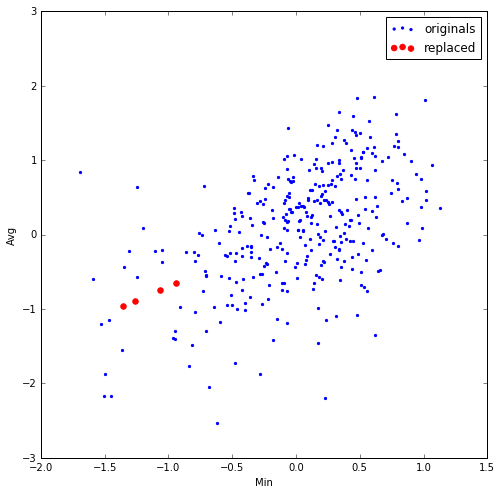

In [55]:
plt.figure(figsize=(8,8))
plt.scatter(df['Max_Treating_pressure (KPa)'][~AvNotMax],df['Avg_Treating_Pressure (KPa)'][~AvNotMax],color='blue',s=5,label='originals')
plt.scatter(df['Max_Treating_pressure (KPa)'][AvNotMax],df['Avg_Treating_Pressure (KPa)'][AvNotMax],color='red',s=30,label='replaced')
plt.ylabel('Avg')
plt.xlabel('Min')
plt.legend()


In [56]:
a3=lin_regr('Min_Treating_Pressure (KPa)','Avg_Treating_Pressure (KPa)')
rows=df[AvNotMin].index
df.loc[rows,'Avg_Treating_Pressure (KPa)']=(df['Min_Treating_Pressure (KPa)'][AvNotMin]- mMi)*a3+ mA

we estimate y= ax+b, with a equals:[ 0.72941962]


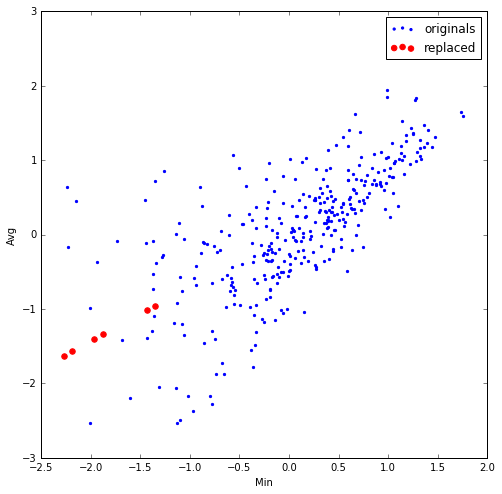

In [57]:
plt.figure(figsize=(8,8))
plt.scatter(df['Min_Treating_Pressure (KPa)'][~AvNotMin],df['Avg_Treating_Pressure (KPa)'][~AvNotMin],color='blue',s=5,label='originals')
plt.scatter(df['Min_Treating_Pressure (KPa)'][AvNotMin],df['Avg_Treating_Pressure (KPa)'][AvNotMin],color='red',s=30,label='replaced')
plt.ylabel('Avg')
plt.xlabel('Min')
plt.legend()

### Missing Min

In [58]:
MinNotAv=np.logical_and(~missing_Atp,missing_Mitp)
print sum(MinNotAv)
MinNotMax=np.logical_and(missing_Mitp,~missing_Matp)
print sum(MinNotMax)

7
7


In [59]:
a3=lin_regr('Max_Treating_pressure (KPa)','Min_Treating_Pressure (KPa)')
rows=df[MinNotMax].index
df.loc[rows,'Min_Treating_Pressure (KPa)']=(df['Max_Treating_pressure (KPa)'][MinNotMax]- mMa)*a3+ mMi

we estimate y= ax+b, with a equals:[ 0.57471105]


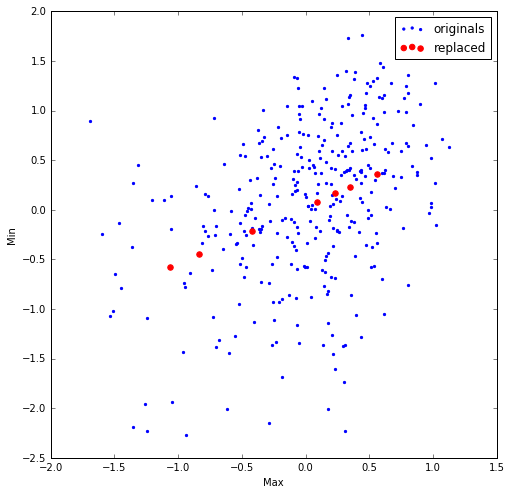

In [60]:
plt.figure(figsize=(8,8))
plt.scatter(df['Max_Treating_pressure (KPa)'][~MinNotMax],df['Min_Treating_Pressure (KPa)'][~MinNotMax],color='blue',s=5,label='originals')
plt.scatter(df['Max_Treating_pressure (KPa)'][MinNotMax],df['Min_Treating_Pressure (KPa)'][MinNotMax],color='red',s=30,label='replaced')
plt.ylabel('Min')
plt.xlabel('Max')
plt.legend()

In [61]:
a3=lin_regr('Avg_Treating_Pressure (KPa)','Min_Treating_Pressure (KPa)')
rows=df[MinNotAv].index
df.loc[rows,'Min_Treating_Pressure (KPa)']=(df['Avg_Treating_Pressure (KPa)'][MinNotAv]- mMa)*a3+ mMi

we estimate y= ax+b, with a equals:[ 0.66324008]


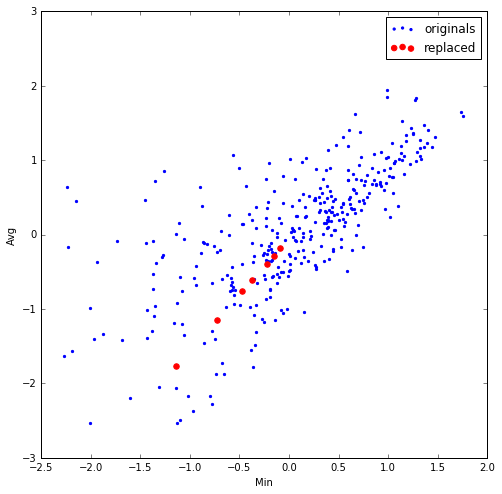

In [62]:
plt.figure(figsize=(8,8))
plt.scatter(df['Min_Treating_Pressure (KPa)'][~MinNotAv],df['Avg_Treating_Pressure (KPa)'][~MinNotAv],color='blue',s=5,label='originals')
plt.scatter(df['Min_Treating_Pressure (KPa)'][MinNotAv],df['Avg_Treating_Pressure (KPa)'][MinNotAv],color='red',s=30,label='replaced')
plt.ylabel('Avg')
plt.xlabel('Min')
plt.legend()

### Missing Max

In [63]:
MaxNotAv=np.logical_and(~missing_Atp,missing_Matp)
print sum(MaxNotAv)
MaxNotMin=np.logical_and(~missing_Mitp,missing_Matp)
print sum(MaxNotMin)

11
13


In [64]:
a3=lin_regr('Min_Treating_Pressure (KPa)','Max_Treating_pressure (KPa)')
rows=df[MaxNotMin].index

df.loc[rows,'Max_Treating_pressure (KPa)']=(df['Min_Treating_Pressure (KPa)'][MaxNotMin]- mMi)*a3+ mMa

we estimate y= ax+b, with a equals:[ 0.27784815]


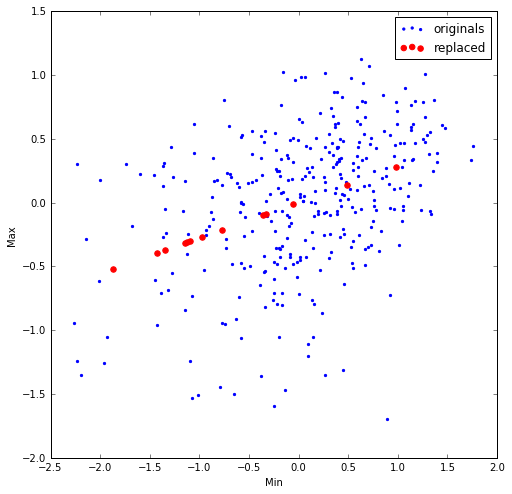

In [65]:
plt.figure(figsize=(8,8))
plt.scatter(df['Min_Treating_Pressure (KPa)'][~MaxNotMin],df['Max_Treating_pressure (KPa)'][~MaxNotMin],color='blue',s=5,label='originals')
plt.scatter(df['Min_Treating_Pressure (KPa)'][MaxNotMin],df['Max_Treating_pressure (KPa)'][MaxNotMin],color='red',s=30,label='replaced')
plt.ylabel('Max')
plt.xlabel('Min')
plt.legend()

In [66]:
a3=lin_regr('Avg_Treating_Pressure (KPa)','Max_Treating_pressure (KPa)')
rows=df[MaxNotAv].index
df.loc[rows,'Max_Treating_pressure (KPa)']=(df['Avg_Treating_Pressure (KPa)'][MaxNotAv]- mMa)*a3+ mMa

we estimate y= ax+b, with a equals:[ 0.33591376]


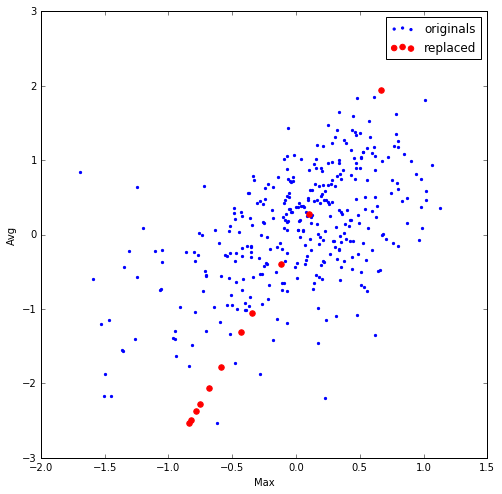

In [67]:
plt.figure(figsize=(8,8))
plt.scatter(df['Max_Treating_pressure (KPa)'][~MaxNotAv],df['Avg_Treating_Pressure (KPa)'][~MaxNotAv],color='blue',s=5,label='originals')
plt.scatter(df['Max_Treating_pressure (KPa)'][MaxNotAv],df['Avg_Treating_Pressure (KPa)'][MaxNotAv],color='red',s=30,label='replaced')
plt.ylabel('Avg')
plt.xlabel('Max')
plt.legend()

In [69]:
missing_Atp=np.isnan(df["Avg_Treating_Pressure (KPa)"])
missing_Mitp=np.isnan(df["Min_Treating_Pressure (KPa)"])
missing_Matp=np.isnan(df["Max_Treating_pressure (KPa)"])
print sum(missing_Atp)
print sum(missing_Mitp)
print sum(missing_Matp)


0
0
0


### Write everything to csv


In [68]:
df.to_csv('clean_data.csv',sep=',',na_rep='na')